# Model free analysis in the Aging project

1. In this notebook I will look at catch trial fails <br>
2. Age effect on proportion <br>
    2.1 age effect on proportion in risky trials <br>
    2.2 age effect on proportion in ambiguous trials <br>
3. cross domain correlations <br> 
4. consistency 

## Load libraries 

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import pymc3 as pm
import arviz as az

import matplotlib
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
age = pd.read_csv('../demo.csv')
db_mon = pd.read_csv('data/mon.csv')
db_med = pd.read_csv('data/med.csv')

print('Participants monetary: ', len(db_mon['sub'].unique()), 'participants medical: ', len(db_med['sub'].unique()))

Participants monetary:  95 participants medical:  95


In [3]:
# make a list with subjects number
s_am = list(age['sub'].unique())
s_ra = list(db_mon['sub'].unique())

# find participant in one list but not in the second
demo_no_ra = list(set(s_am)- set(s_ra))
ra_no_demo = list(set(set(s_ra)- set(s_am)))

print ('pariticpant with R&A and no MoCA:', ra_no_demo)
print ('pariticpant with MoCA and no R&A:', demo_no_ra)

age = age[age['sub'].isin(db_mon['sub'].values)]

# remove participants without age/moca from the db and add age, moca and gender
db_mon = db_mon.merge(age, left_on='sub', right_on='sub')
db_med = db_med.merge(age, left_on='sub', right_on='sub')

db_mon = db_mon[db_mon['moca_score']>25]
db_med = db_med[db_med['moca_score']>25]


print('Number of participants with all data:', len(db_med['sub'].unique()))

pariticpant with R&A and no MoCA: [64, 65, 67, 70, 12, 79, 81, 84, 21, 22, 89, 91, 31, 97, 34, 35, 98, 99, 45, 110, 47, 48, 111, 112, 53, 54, 62]
pariticpant with MoCA and no R&A: []
Number of participants with all data: 68


In [4]:
risk_min = 2 # the minimum number of trials participant chose the lottery.

# collect number of lottery selection by subject
choices_mon = db_mon[['sub','choice']].groupby(['sub']).sum()
choices_med = db_med[['sub','choice']].groupby(['sub']).sum()

# get the subject number for participant who were too risk averse
too_risk_averse_mon = list(choices_mon[choices_mon['choice']<risk_min].index)
too_risk_averse_med = list(choices_med[choices_med['choice']<risk_min].index)

print('Monetary too risk averse (', risk_min, '): ', too_risk_averse_mon)
print('Medical too risk averse (', risk_min, '): ', too_risk_averse_med)


# remove too risk averse particiants from the files
db_mon = db_mon[~db_mon['sub'].isin(too_risk_averse_mon)]
db_med = db_med[~db_med['sub'].isin(too_risk_averse_med)]

# compare monetary and medical lists and keep only valid participants in both
mon_s = list(db_mon['sub'].unique())
med_s = list(db_med['sub'].unique())

db_mon = db_mon[db_mon['sub'].isin(med_s)]
db_med = db_med[db_med['sub'].isin(mon_s)]

print('Final sample of participants with R&A data: ', len(db_med['sub'].unique()))

Monetary too risk averse ( 2 ):  [11, 40]
Medical too risk averse ( 2 ):  []
Final sample of participants with R&A data:  66


In [5]:
# average number of times participants chose the lottery in catch trials
catch_mon = pd.DataFrame(db_mon[db_mon.value==5].groupby('sub').mean()['choice'])
catch_med = pd.DataFrame(db_med[db_med.value==5].groupby('sub').mean()['choice'])

# merge data sets
catch = catch_mon.merge(catch_med, left_on='sub', right_on='sub')

# create a mean catch across trials
catch['choice'] = (catch.choice_x +  catch.choice_y)/2

catch.columns = ['Montary', 'Medical', 'OverAll']
#Subjects who failed catch trials
print(catch[catch['OverAll']>0.5].head())
catch = catch[catch['OverAll']<0.5].reset_index()

catch_s = list(catch['sub'].unique())

db_mon = db_mon[db_mon['sub'].isin(catch_s)]
db_med = db_med[db_med['sub'].isin(catch_s)]

      Montary   Medical   OverAll
sub                              
17   0.916667  0.500000  0.708333
27   0.916667  0.333333  0.625000


In [6]:
db_mon = db_mon.dropna()
db_med = db_med.dropna()

mon_prop = db_mon.groupby('sub').mean()
med_prop = db_med.groupby('sub').mean()

## Use robust regression to check an association between age and proportion

In [7]:
def corr(df):
    with pm.Model() as RR:

        a = pm.Normal('intercept', 0, 1)
        b = pm.Normal('slope', 0, 1)
        eps = pm.Exponential('eps', 1)
        y_hat = a + b*df.x

        nu = pm.InverseGamma("nu", alpha=3, beta=1)

        #likelihood = pm.Normal("likelihood", mu=y_hat, sigma=eps, observed=df.y)

        likelihood = pm.StudentT("likelihood", mu=y_hat, sigma=eps, nu=nu, observed=df.y)

        trace_robust = pm.sample(tune=3000, draws=1000, return_inferencedata=True, target_accept=0.95)
        
    return(trace_robust)

In [8]:
mon_age_trace = corr(pd.DataFrame({'x': mon_prop.age/100, 'y': mon_prop.choice}).reset_index(drop=True))
med_age_trace = corr(pd.DataFrame({'x': med_prop.age/100, 'y': med_prop.choice}).reset_index(drop=True))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 7 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 7 seconds.


In [9]:
mon_prop_age = az.summary(mon_age_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
med_prop_age = az.summary(med_age_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(20, 0.89, 'β = -0.06,\n89% HDPi [-0.24, 0.12]')

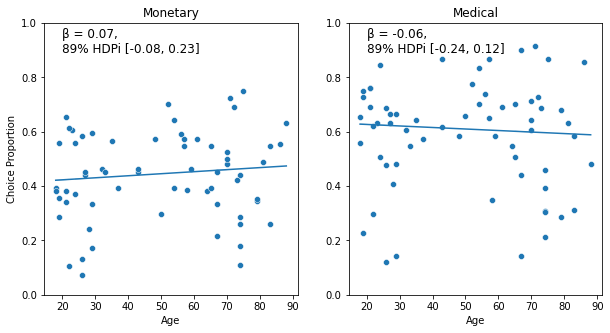

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(y = 'choice', x = 'age', data=mon_prop, ax=axes[0])
sns.scatterplot(y = 'choice', x = 'age', data=med_prop, ax=axes[1])

sns.lineplot(mon_prop.age,mon_prop_age['mean']['intercept']+mon_prop_age['mean']['slope']*mon_prop.age/100, ax=axes[0])
sns.lineplot(med_prop.age,med_prop_age['mean']['intercept']+med_prop_age['mean']['slope']*med_prop.age/100, ax=axes[1])

axes[0].set(ylim=(0, 1), xlabel='Age', ylabel='Choice Proportion', title='Monetary')
axes[1].set(ylim=(0, 1), xlabel='Age', ylabel=None, title='Medical')


text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(mon_prop_age['mean']['slope']),
                                                        float(mon_prop_age['hdi_5.5%']['slope']),
                                                        float(mon_prop_age['hdi_94.5%']['slope']))
axes[0].text(20, .89, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(med_prop_age['mean']['slope']),
                                                        float(med_prop_age['hdi_5.5%']['slope']),
                                                        float(med_prop_age['hdi_94.5%']['slope']))
axes[1].text(20, .89, text, fontsize=12)


In [11]:
mon_risk_prop = db_mon[(db_mon.choice == 1) & (db_mon.ambiguity == 0)].groupby('sub').count()['choice']/db_mon[(db_mon.ambiguity == 0)].groupby('sub').count()['choice']
mon_ambg_prop = db_mon[(db_mon.choice == 1) & (db_mon.ambiguity >  0)].groupby('sub').count()['choice']/db_mon[(db_mon.ambiguity >  0)].groupby('sub').count()['choice']

med_risk_prop = db_med[(db_med.choice == 1) & (db_med.ambiguity == 0)].groupby('sub').count()['choice']/db_med[(db_med.ambiguity == 0)].groupby('sub').count()['choice']
med_ambg_prop = db_med[(db_med.choice == 1) & (db_med.ambiguity >  0)].groupby('sub').count()['choice']/db_med[(db_med.ambiguity >  0)].groupby('sub').count()['choice']

mon_risk_prop = mon_risk_prop.replace(np.nan, 0)
mon_ambg_prop = mon_ambg_prop.replace(np.nan, 0)
med_risk_prop = med_risk_prop.replace(np.nan, 0)
med_ambg_prop = med_ambg_prop.replace(np.nan, 0)

mon_risk_prop=mon_risk_prop.reset_index()
mon_ambg_prop=mon_ambg_prop.reset_index()
med_risk_prop=med_risk_prop.reset_index()
med_ambg_prop=med_ambg_prop.reset_index()

In [12]:
# get participants response at 0.5 risk and no ambiguity for ambiguity corrections
amb_correction_mon = db_mon[(db_mon['ambiguity'] == 0) & (db_mon['risk'] == 0.5)][['sub','value','choice']]
amb_correction_mon = amb_correction_mon.groupby(['sub','value']).mean()
amb_correction_mon.reset_index(inplace=True)

amb_correction_med = db_med[(db_med['ambiguity'] == 0) & (db_med['risk'] == 0.5)][['sub','value','choice']]
amb_correction_med = amb_correction_med.groupby(['sub','value']).mean()
amb_correction_med.reset_index(inplace=True)

In [13]:
mon_ambg_prop = mon_ambg_prop.merge(amb_correction_mon.groupby('sub').mean(), left_on='sub', right_on='sub')
med_ambg_prop = med_ambg_prop.merge(amb_correction_med.groupby('sub').mean(), left_on='sub', right_on='sub')

mon_ambg_prop['choice'] = mon_ambg_prop.choice_x-mon_ambg_prop.choice_y
med_ambg_prop['choice'] = med_ambg_prop.choice_x-med_ambg_prop.choice_y

In [14]:
proportion = mon_risk_prop.merge(med_risk_prop, left_on='sub', right_on='sub')

proportion = proportion.merge(mon_ambg_prop[['sub','choice']], left_on='sub', right_on='sub')
proportion = proportion.merge(med_ambg_prop[['sub','choice']], left_on='sub', right_on='sub')

proportion.columns = ['sub', 'MontaryRisk', 'MedicalRisk', 'MontaryAmb', 'MedicalAmb']
proportion = proportion.merge(age, left_on='sub', right_on='sub')

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'choice_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [15]:
risk_trace = corr(pd.DataFrame({'x': proportion.MontaryRisk, 'y': proportion.MedicalRisk}).reset_index(drop=True))
ambg_trace = corr(pd.DataFrame({'x': proportion.MontaryAmb, 'y': proportion.MedicalAmb}).reset_index(drop=True))

risk = az.summary(risk_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
ambg = az.summary(ambg_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 4 seconds.


In [16]:
norm = matplotlib.colors.Normalize(vmin=18, vmax=90)
colors = {}
cmap = sns.diverging_palette(240, 10, as_cmap=True )

for cval in range(18,90):
    colors.update({cval : cmap(norm(cval))})
    

/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


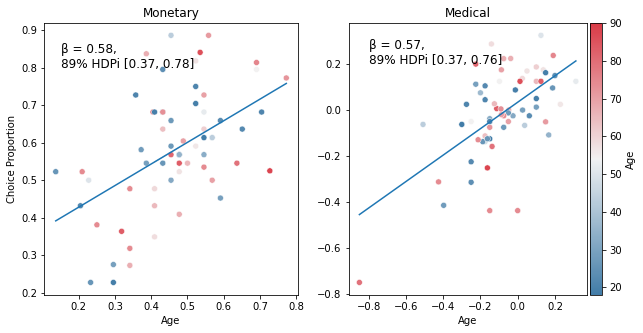

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(y = 'MedicalRisk', x = 'MontaryRisk', data=proportion, ax=axes[0], hue = 'age', palette = colors)
sns.scatterplot(y = 'MedicalAmb', x = 'MontaryAmb', data=proportion, ax=axes[1], hue = 'age', palette = colors)

sns.lineplot(proportion.MontaryRisk,risk['mean']['intercept']+risk['mean']['slope']*proportion.MontaryRisk, ax=axes[0])
sns.lineplot(proportion.MontaryAmb,ambg['mean']['intercept']+ambg['mean']['slope']*proportion.MontaryAmb, ax=axes[1])

axes[0].set(xlabel='Age', ylabel='Choice Proportion', title='Monetary')
axes[1].set(xlabel='Age', ylabel=None, title='Medical')


text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(risk['mean']['slope']),
                                                        float(risk['hdi_5.5%']['slope']),
                                                        float(risk['hdi_94.5%']['slope']))
axes[0].text(.15, .8, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(ambg['mean']['slope']),
                                                        float(ambg['hdi_5.5%']['slope']),
                                                        float(ambg['hdi_94.5%']['slope']))
axes[1].text(-.8, .2, text, fontsize=12)

#fig.suptitle('Correlation of Choice Behavior within Domains', fontsize=16)

axes[0].legend_.remove()
axes[1].legend_.remove()


## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()


In [18]:
mon_trace = corr(pd.DataFrame({'x': proportion.MontaryRisk, 'y': proportion.MontaryAmb}).reset_index(drop=True))
med_trace = corr(pd.DataFrame({'x': proportion.MedicalRisk, 'y': proportion.MedicalAmb}).reset_index(drop=True))

mon = az.summary(mon_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
med = az.summary(med_trace, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 8 seconds.


/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


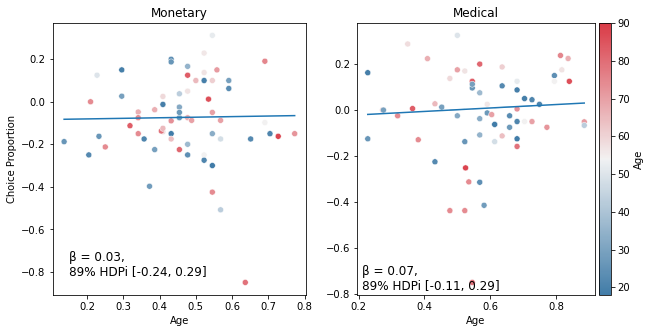

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x = 'MontaryRisk', y = 'MontaryAmb', data=proportion, ax=axes[0], hue = 'age', palette = colors)
sns.scatterplot(x = 'MedicalRisk', y = 'MedicalAmb', data=proportion, ax=axes[1], hue = 'age', palette = colors)

sns.lineplot(proportion.MontaryRisk,mon['mean']['intercept']+mon['mean']['slope']*proportion.MontaryRisk, ax=axes[0])
sns.lineplot(proportion.MedicalRisk,med['mean']['intercept']+med['mean']['slope']*proportion.MedicalRisk, ax=axes[1])

axes[0].set(xlabel='Age', ylabel='Choice Proportion', title='Monetary')
axes[1].set(xlabel='Age', ylabel=None, title='Medical')


text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(mon['mean']['slope']),
                                                        float(mon['hdi_5.5%']['slope']),
                                                        float(mon['hdi_94.5%']['slope']))
axes[0].text(.15, -.82, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(med['mean']['slope']),
                                                        float(med['hdi_5.5%']['slope']),
                                                        float(med['hdi_94.5%']['slope']))
axes[1].text(.21, -.78, text, fontsize=12)

#fig.suptitle('Correlation of Choice Behavior between Domains', fontsize=16)

axes[0].legend_.remove()
axes[1].legend_.remove()


## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()



In [20]:
const = db_mon.groupby(['sub','age', 'risk', 'ambiguity', 'value']).sum()['choice'].reset_index()
const['score'] = np.where(const['choice']==4, 0, 
                          np.where(const['choice']==3, 1, 
                                   np.where(const['choice']==2, 2, const['choice'])))
const = const.groupby(['sub','age']).sum()['score'].reset_index()

const_med = db_med.groupby(['sub','age', 'risk', 'ambiguity', 'value']).sum()['choice'].reset_index()
const_med['score'] = np.where(const_med['choice']==4, 0, 
                          np.where(const_med['choice']==3, 1, 
                                   np.where(const_med['choice']==2, 2, const_med['choice'])))
const_med = const_med.groupby(['sub','age']).sum()['score'].reset_index()

In [21]:
inc_mon = corr(pd.DataFrame({'x': const.age/10, 'y': const.score}).reset_index(drop=True))
inc_med = corr(pd.DataFrame({'x': const_med.age/10,  'y': const_med.score}).reset_index(drop=True))

incMon = az.summary(inc_mon, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
incMed  = az.summary(inc_med,  var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, eps, slope, intercept]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 6 seconds.


/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/nachshon/anaconda3/envs/reversal/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(20, 15, 'β = 0.57,\n89% HDPi [0.30, 0.84]')

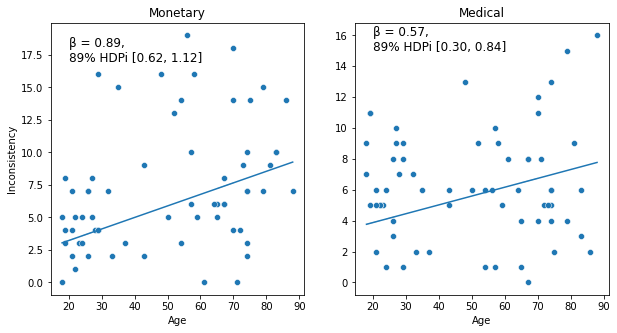

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
#fig.suptitle('Correlation of Age and Inconsistency', fontsize=16)

sns.scatterplot(x = 'age', y = 'score', data=const, ax=axes[0])
sns.scatterplot(x = 'age', y = 'score', data=const_med, ax=axes[1])

sns.lineplot(const.age,incMon['mean']['intercept']+incMon['mean']['slope']*const.age/10, ax=axes[0])
sns.lineplot(const_med.age,incMed['mean']['intercept']+incMed['mean']['slope']*const_med.age/10, ax=axes[1])

axes[0].set(xlabel='Age', ylabel='Inconsistency', title='Monetary')
axes[1].set(xlabel='Age', ylabel=None, title='Medical')


text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(incMon['mean']['slope']),
                                                        float(incMon['hdi_5.5%']['slope']),
                                                        float(incMon['hdi_94.5%']['slope']))
axes[0].text(20, 17, text, fontsize=12)

text = 'β = {:.2f},\n89% HDPi [{:.2f}, {:.2f}]'.format(float(incMed['mean']['slope']),
                                                        float(incMed['hdi_5.5%']['slope']),
                                                        float(incMed['hdi_94.5%']['slope']))
axes[1].text(20, 15, text, fontsize=12)



In [23]:
proportion.to_csv('data/prop.csv')
const.to_csv('data/const_mon.csv')
const_med.to_csv('data/const_med.csv')